# Neural Network Development Notebook

In [14]:
# %% Load libraries
import jax
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
from jaxtyping import Float, Array, PyTree
import jax.numpy as jnp
import optax

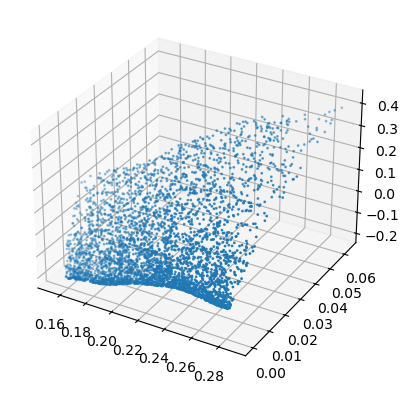

In [2]:
# %% Load and filter data
orbit_data = np.load('./tests/orbit_data.npz')

lphi = orbit_data['lphi']
action = orbit_data['action']
ham = orbit_data['ham']
winding_pol = orbit_data['winding_pol']
winding_vll = orbit_data['winding_vll']

pfilter = np.logical_and((np.round(winding_pol) == 0), (np.round(winding_vll) == +1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(lphi[pfilter], action[pfilter], ham[pfilter], s=1)

In [49]:
# %% Define neural network
class NeuralNetwork(eqx.Module):
    layers: list

    def __init__(self, key):
        keys = jax.random.split(key, 5)

        self.layers = [
            eqx.nn.Linear(2, 64, key=keys[0]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=keys[1]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 64, key=keys[2]),
            jax.nn.tanh,
            eqx.nn.Linear(64, 1, key=keys[4])
        ]

    def __call__(self, x: Float[Array, "2"]) -> Float[Array, "1"]:
        for layer in self.layers:
            x = layer(x)
        return x

In [50]:
key = jax.random.key(0)
model0 = NeuralNetwork(key)

In [51]:
# %% Define the loss function
@eqx.filter_jit
def loss(
        model: NeuralNetwork,
        x: Float[Array, "batch 2"],
        y_true: Float[Array, "batch 1"]
) -> Float:
    y_pred = jax.vmap(model)(x)
    return jnp.mean((y_pred - y_true) ** 2)

In [57]:
x_all = jnp.array(np.vstack((lphi[pfilter] / np.std(lphi[pfilter]), action[pfilter] / np.std(action[pfilter]))).T)
y_all = jnp.array([ham[pfilter] / np.std(ham[pfilter])]).T

loss(model0, x_all, y_all)

Array(1.0639112, dtype=float32)

In [ ]:
# %% Train the model

optim = optax.adamw(1e-3)

model = model0
opt_state = optim.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def make_step(
    model: NeuralNetwork,
    opt_state: PyTree,
    x: Float[Array, "batch 2"],
    y: Float[Array, "batch 1"],
):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optim.update(
        grads, opt_state, eqx.filter(model, eqx.is_array)
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

# Select a subset of data for training
n_train = 1024
x_train = x_all[:n_train,:]
y_train = y_all[:n_train,:]

losses = []

for epoch in range(20000):
    x_batch = x_train[epoch % 16 * (n_train // 16):(epoch % 16 + 1) * (n_train // 16), :]
    y_batch = y_train[epoch % 16 * (n_train // 16):(epoch % 16 + 1) * (n_train // 16), :]

    model, opt_state, loss_value = make_step(
        model,
        opt_state,
        x_batch,
        y_batch
    )
    losses.append(loss_value)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value}")

Epoch 0, Loss: 1.111283302307129
Epoch 1000, Loss: 0.013194023631513119
Epoch 2000, Loss: 0.010869721882045269
Epoch 3000, Loss: 0.00941344816237688
Epoch 4000, Loss: 0.00805580522865057
Epoch 5000, Loss: 0.006498035974800587
Epoch 6000, Loss: 0.0015189063269644976
Epoch 7000, Loss: 0.0009029971552081406
Epoch 8000, Loss: 0.000804871553555131
Epoch 9000, Loss: 0.0007015549927018583
Epoch 10000, Loss: 0.0005893989000469446
Epoch 11000, Loss: 0.0004245911259204149
Epoch 12000, Loss: 0.000338665209710598
Epoch 13000, Loss: 0.0003002968442160636
Epoch 14000, Loss: 0.00026929989689961076
Epoch 15000, Loss: 0.0002410310844425112
Epoch 16000, Loss: 0.00021789064339827746
Epoch 17000, Loss: 0.00011200102744624019
Epoch 18000, Loss: 6.43949824734591e-05
Epoch 19000, Loss: 6.591704732272774e-05


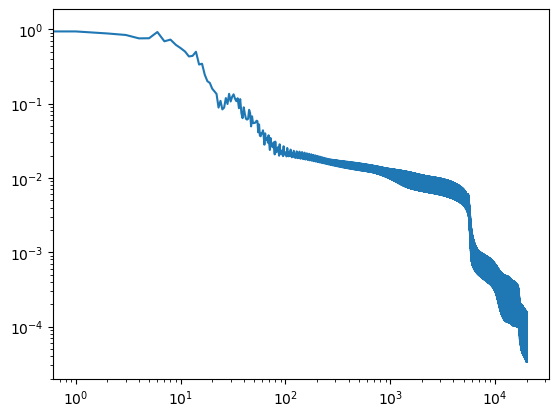

In [72]:
plt.figure()
plt.loglog(losses)

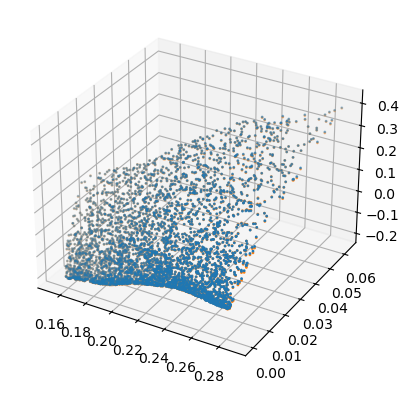

In [73]:
# %% Test the model
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(lphi[pfilter], action[pfilter], ham[pfilter], s=1)
ax.scatter(lphi[pfilter], action[pfilter], jax.vmap(model)(x_all)[:,0] * np.std(ham[pfilter]), s=1)

In [46]:
len(x_all)

3761

In [9]:
y_temp.shape

(3761, 1)